In [2]:
import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import tokenizers
import transformers
from transformers import AutoTokenizer, EncoderDecoderModel, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
from datasets.utils.logging import disable_progress_bar
from rdkit import Chem
import rdkit
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
disable_progress_bar()

    
# CFG = parse_args()

class CFG:
    model = 't5'
    dataset_path = '/data2/sagawa/tcrp-multiinput-archive/12-3-agg-into-reagent-w-nodata/multi-input-test.csv'
    model_name_or_path = '/data2/sagawa/tcrp-multiinput-archive/12-3-agg-into-reagent-w-nodata/t5/checkpoint-1986462'
    num_beams = 5
    num_return_sequences = 5
    debug = True
    seed = 42
    
device = 'cpu'

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=CFG.seed)  

from rdkit.Chem import Descriptors
from rdkit import Chem
def get_weight(row):
    if row == ' ':
        return 0
    weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(row))
    return weight
    
    
dataset = pd.read_csv(CFG.dataset_path)

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name_or_path, return_tensors='pt')

colors = list(mcolors.CSS4_COLORS.keys())

test = pd.read_csv('multi-input-test.csv')
test = test.reset_index(drop=True)[:5000]
test

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT,input
0,COC(=O)C1=CCCN(C)C1.O.[Al+3].[H-].[Li+].[Na+]....,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,C1CCOC1,C1CCOC1,REACTANT:COC(=O)C1=CCCN(C)C1.O.[Al+3].[H-].[Li...
1,Cc1cc(C=O)cc(C)c1OCCO.Nc1ccccc1C(=O)Nc1ccc(Br)cc1,Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1,Cl[Cu]Cl,CCO.Cl[Cu]Cl,CCO,REACTANT:Cc1cc(C=O)cc(C)c1OCCO.Nc1ccccc1C(=O)N...
2,O=C([O-])[O-].O=[N+]([O-])c1ccccc1F.Oc1ccc(Cl)...,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,,CN(C)C=O,CN(C)C=O,REACTANT:O=C([O-])[O-].O=[N+]([O-])c1ccccc1F.O...
3,CCOC=O.COC(=O)[C@@H]1CNC[C@H]1c1ccc(OC)c(OC2CC...,CCc1c(Cc2[nH]c(C(=O)OCc3ccccc3)c(C)c2CCC(=O)OC...,,CCOCC,CCOCC,REACTANT:CCOC=O.COC(=O)[C@@H]1CNC[C@H]1c1ccc(O...
4,CC(C)NS(=O)(=O)Cl.ClCCCl.O=C(Cl)Cl.c1ccncc1,O=C1NS(=O)(=O)CN1c1ccc(Cl)cc1,,O,O,REACTANT:CC(C)NS(=O)(=O)Cl.ClCCCl.O=C(Cl)Cl.c1...
...,...,...,...,...,...,...
4995,CCC(C)(C)CC(O)CN.CCN=C=NCCCN(C)C.CN1CCOCC1.Cl....,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,,CCOC(C)=O.ClCCl,CCOC(C)=O.ClCCl,REACTANT:CCC(C)(C)CC(O)CN.CCN=C=NCCCN(C)C.CN1C...
4996,C=CCOC1(C)CCN(c2c([C@H](OC(C)(C)C)C(=O)OC)c(C)...,CCOC(=O)c1cccc(-c2cn(-c3ccc(F)c(F)c3)nc2C(=O)O...,,,,REACTANT:C=CCOC1(C)CCN(c2c([C@H](OC(C)(C)C)C(=...
4997,CCOC(=O)CN1CCCC1.CN(C)CCO.[H-].[Na+],O=C(O)CC(O)(CC(=O)O)C(=O)O.O=C[O-].O=C[O-].[Cu+2],,,,REACTANT:CCOC(=O)CN1CCCC1.CN(C)CCO.[H-].[Na+]R...
4998,CC(C)(C)OC(=O)N(C(=O)OC(C)(C)C)c1ncc(B2OC(C)(C...,FC(F)(F)C(Cl)=NN=C(Cl)C(F)(F)F,CN(C)c1ccc(P(C(C)(C)C)C(C)(C)C)cc1.Cl[Pd]Cl,CCOC(C)=O.CN(C)C=O.CN(C)c1ccc(P(C(C)(C)C)C(C)(...,CCOC(C)=O.CN(C)C=O.O,REACTANT:CC(C)(C)OC(=O)N(C(=O)OC(C)(C)C)c1ncc(...


In [45]:
# create a distance matrix from embedding
# outputs = np.load('embedding_5000.npy')
# print(outputs.shape)

# dist_matrix = np.zeros([len(outputs),len(outputs)])

# for i in range(len(outputs)):
#     for j in range(len(outputs)):
#         dist = np.linalg.norm(outputs[i] - outputs[j])
#         dist_matrix[i][j] = dist

# np.save('distance_5000.npy', dist_matrix)
dist_matrix = np.load('/data2/sagawa/tcrp-multiinput-archive/12-3-agg-into-reagent-w-nodata/distance_5000.npy')

In [46]:
# outputs = np.load('embedding_cls_5000.npy')
# outputs = outputs[:, 0, :]
# outputs.shape

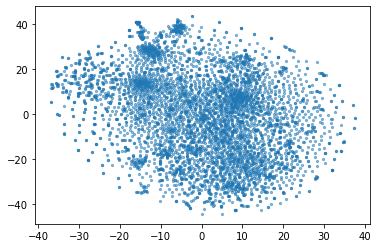

In [85]:
tsne = TSNE(n_components=2, random_state=42, metric='precomputed')
tsne_out = tsne.fit_transform(dist_matrix)
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

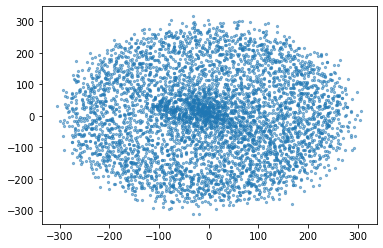

In [7]:
mds = MDS(n_components=2, random_state=42, dissimilarity='precomputed')
mds_out = mds.fit_transform(dist_matrix)
plt.scatter(mds_out[:, 0], mds_out[:, 1], alpha=0.5, s=5)

In [48]:
catalyst_c = {k: c for k, c in zip(test['CATALYST'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])}
catalyst_c.update({k: '#e41a1c' for k in test['CATALYST'].value_counts()[20:].keys()})

# dist_matrix = np.load('distance_5000.npy')
test['c'] = test['CATALYST'].map(catalyst_c)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{' ': 'lightgrey', '[Pd]': 'aliceblue', 'c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1': 'antiquewhite', 'CN(C)c1ccncc1': 'aqua', 'CC(=O)[O-].[Pd+2]': 'aquamarine', 'O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.[Pd]': 'azure', 'Cl[Pd]Cl.[Fe+2].c1ccc(P(c2ccccc2)[c-]2cccc2)cc1': 'beige', '[Fe]': 'bisque', '[Ni]': 'black', '[Cu]I': 'blanchedalmond', 'Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1': 'blue', '[Zn]': 'blueviolet', 'CN(C)C=O': 'brown', '[C].[Pd]': 'burlywood', '[OH-].[Pd+2]': 'cadetblue', '[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1': 'chartreuse', 'Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1.[Cu]I': 'chocolate', '[Mn+4].[O-2]': 'coral', 'CCCC[N+](CCCC)(CCCC)CCCC.[Br-]': 'cornflowerblue', '[Cl-].[Zn+2]': 'cornsilk'}


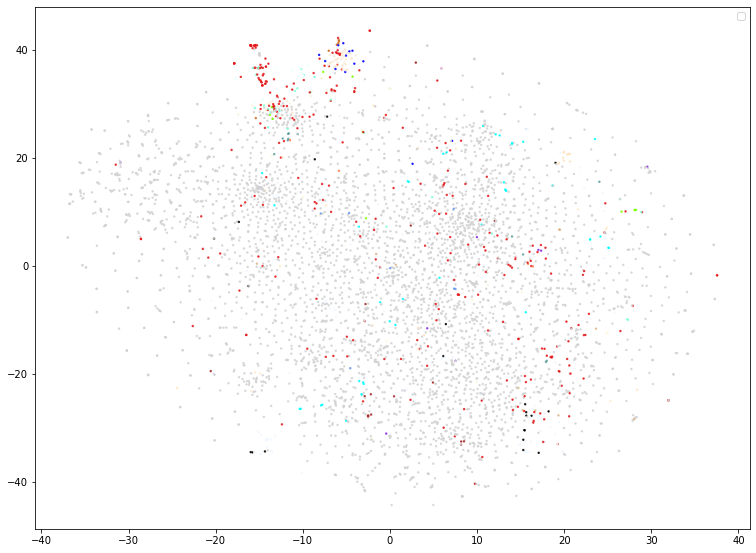

In [49]:
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, color=test['c'])
plt.legend()
print({k: c for k, c in zip(test['CATALYST'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])})

In [52]:
reagent_c = {k: c for k, c in zip(test['REAGENT'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])}
reagent_c.update({k: '#e41a1c' for k in test['REAGENT'].value_counts()[20:].keys()})
test['c'] = test['REAGENT'].map(reagent_c)

{' ': 'lightgrey', 'ClCCl': 'aliceblue', 'C1CCOC1': 'antiquewhite', 'CN(C)C=O': 'aqua', 'CCO': 'aquamarine', 'CO': 'azure', 'O': 'beige', 'CC#N': 'bisque', 'Cc1ccccc1': 'black', 'CCOC(C)=O': 'blanchedalmond', 'C1COCCO1': 'blue', 'CC(=O)O': 'blueviolet', 'CCOCC': 'brown', 'C1CCOC1.O': 'burlywood', 'CN(C)C=O.O': 'cadetblue', 'c1ccncc1': 'chartreuse', 'CC(C)=O': 'chocolate', 'ClC(Cl)Cl': 'coral', 'CO.[Pd]': 'cornflowerblue', 'CS(C)=O': 'cornsilk'}


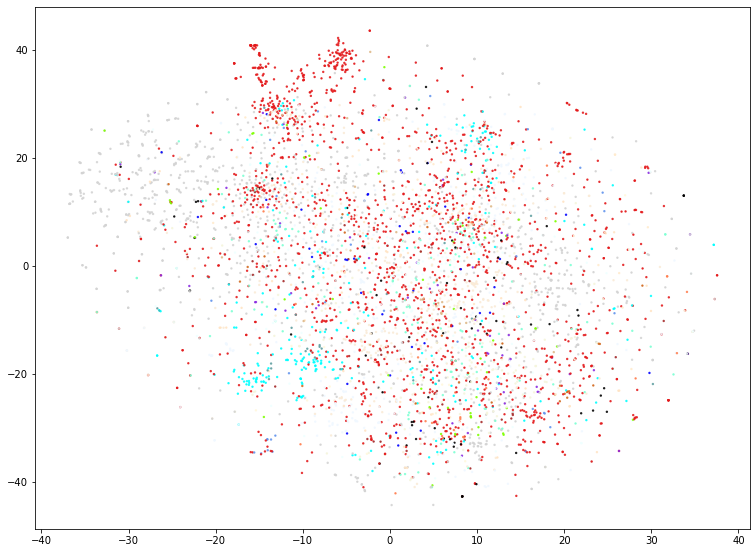

In [53]:
# colored based on reagent
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, color=test['c'])
print({k: c for k, c in zip(test['REAGENT'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])})

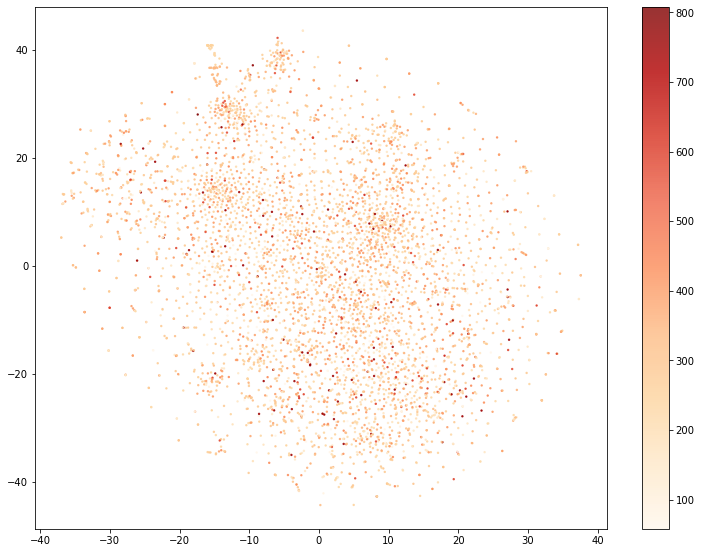

In [86]:
# colored based on product's weight
test['product_weight'] = test['PRODUCT'].apply(get_weight)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['product_weight'], cmap='OrRd')
plt.colorbar()

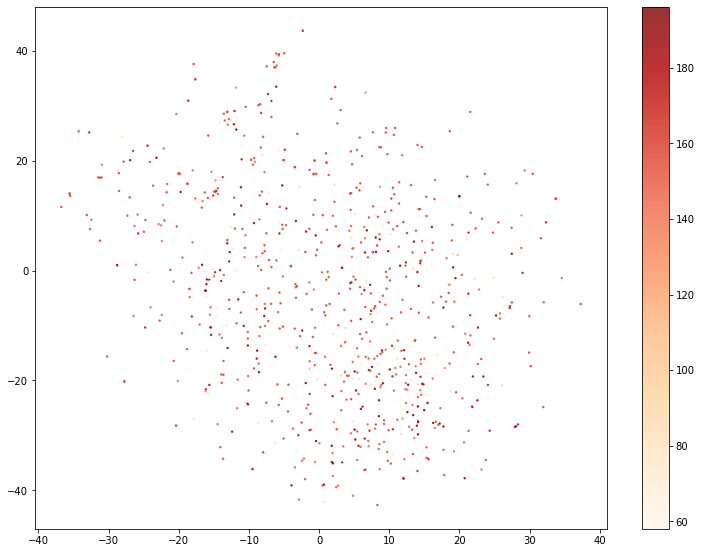

In [87]:
# colored based on product's weight (weight < 500)
index = np.array(test[test['product_weight'] < 200].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[test['product_weight'] < 200]['product_weight'], cmap='OrRd')
plt.colorbar()

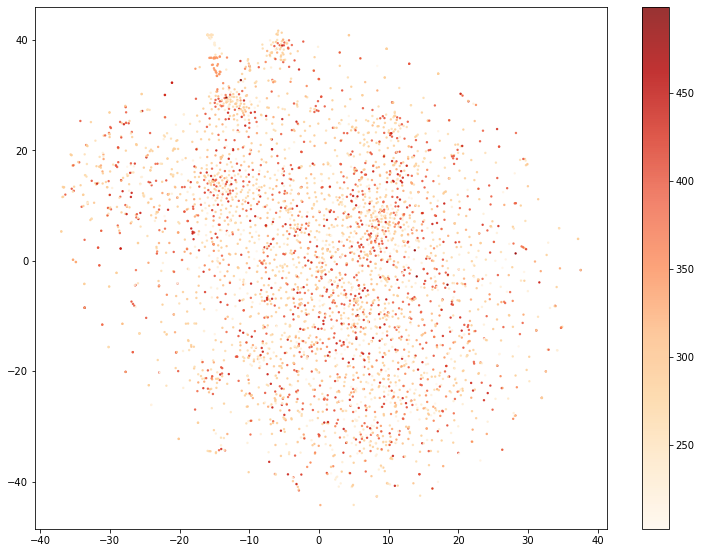

In [88]:
# colored based on product's weight (200<= weight < 500)
index = np.array(test[(test['product_weight'] >= 200) & (test['weight'] < 500)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['product_weight'] >= 200) & (test['product_weight'] < 500)]['product_weight'], cmap='OrRd')
plt.colorbar()

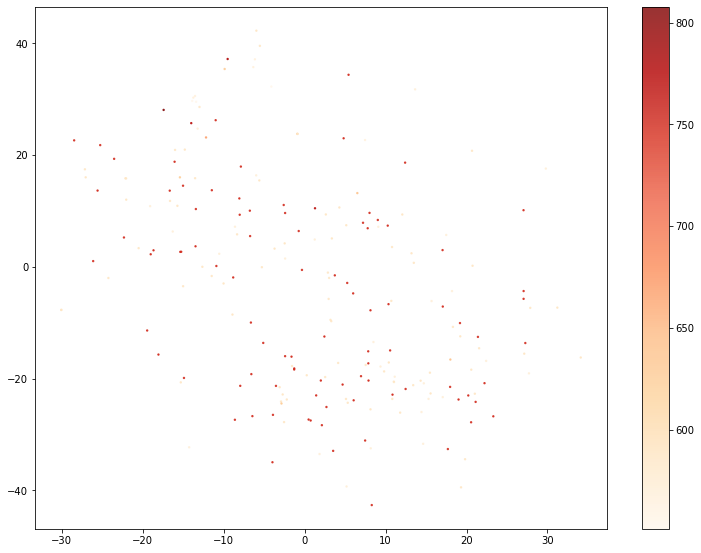

In [89]:
# colored based on product's weight (weight >= 500)
index = np.array(test[(test['product_weight'] >= 500)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['product_weight'] >= 500)]['product_weight'], cmap='OrRd')
plt.colorbar()

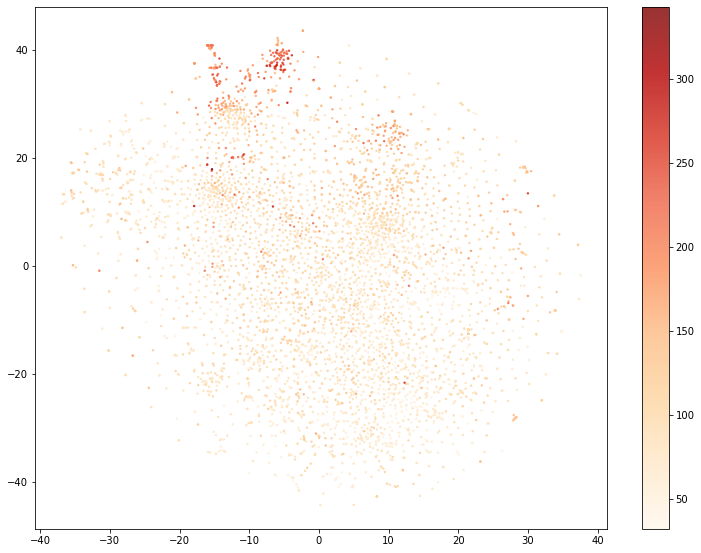

In [61]:
# colored based on input length
test['len'] = df.loc[test.index]['input'].str.len()
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['len'], cmap='OrRd')
plt.colorbar()

In [73]:
test['reactant_weight'] = test['REACTANT'].apply(get_weight)
test['reagent_weight'] = test['REAGENT'].apply(get_weight)
test['solvent_weight'] = test['SOLVENT'].apply(get_weight)
test['input_weight'] = test['reactant_weight'] + test['reagent_weight'] + test['solvent_weight'] 

[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not removing hydrogen atom without neighbors
[17:37:24] WARNING: not r

[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not removing hydrogen atom without neighbors
[17:37:25] WARNING: not r

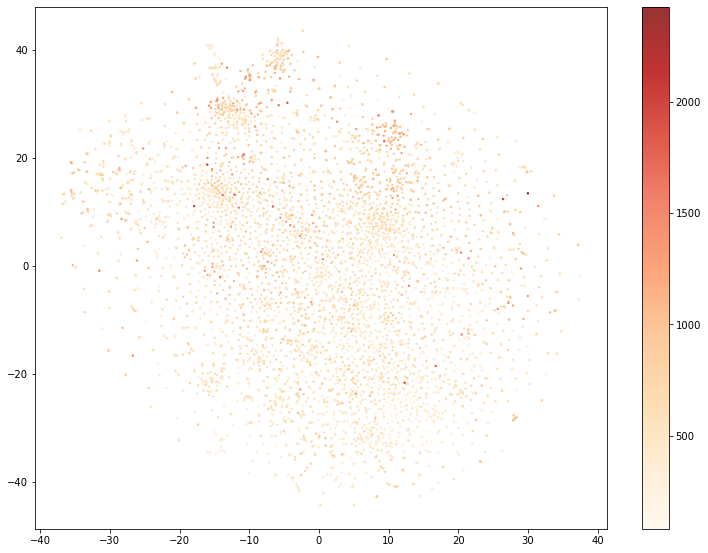

In [63]:
# colored based on reactant's weight
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['reactant_weight'], cmap='OrRd')
plt.colorbar()

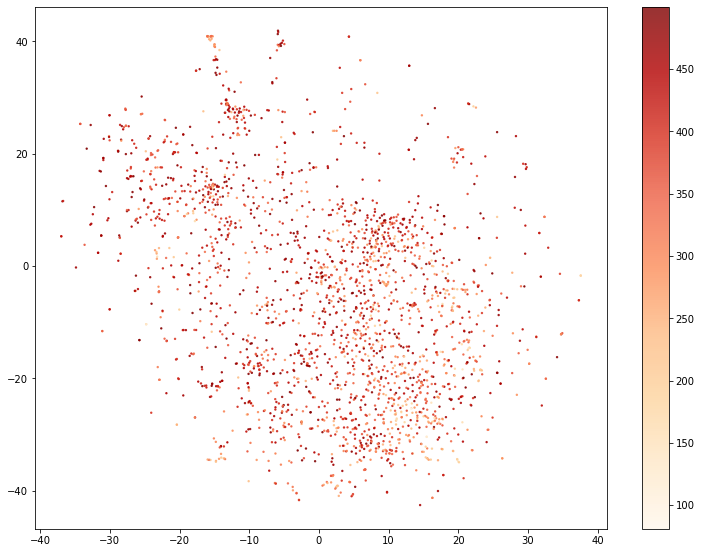

In [64]:
# colored based on reactant's weight (weight < 500)
index = np.array(test[test['reactant_weight'] < 500].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[test['reactant_weight'] < 500]['reactant_weight'], cmap='OrRd')
plt.colorbar()

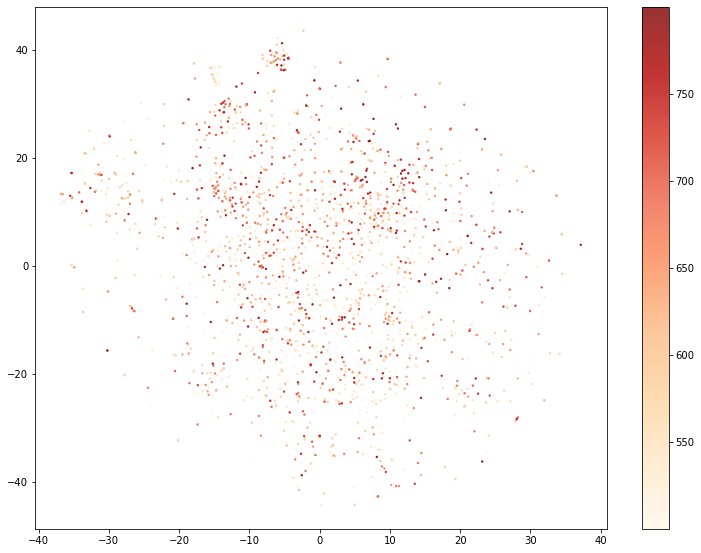

In [66]:
# colored based on reactant's weight (500 <= weight < 800)
index = np.array(test[(test['reactant_weight'] >= 500) & (test['reactant_weight'] < 800)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['reactant_weight'] >= 500) & (test['reactant_weight'] < 800)]['reactant_weight'], cmap='OrRd')
plt.colorbar()

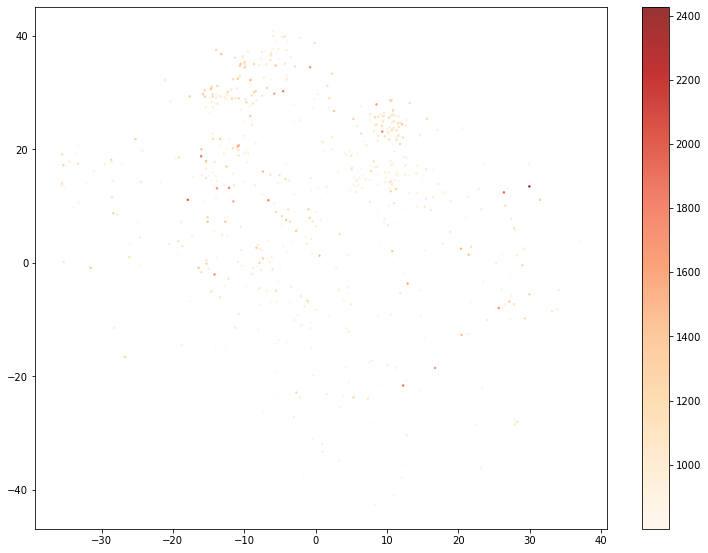

In [67]:
# colored based on reactant's weight (weight >= 800)
index = np.array(test[(test['reactant_weight'] >= 800)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['reactant_weight'] >= 800)]['reactant_weight'], cmap='OrRd')
plt.colorbar()

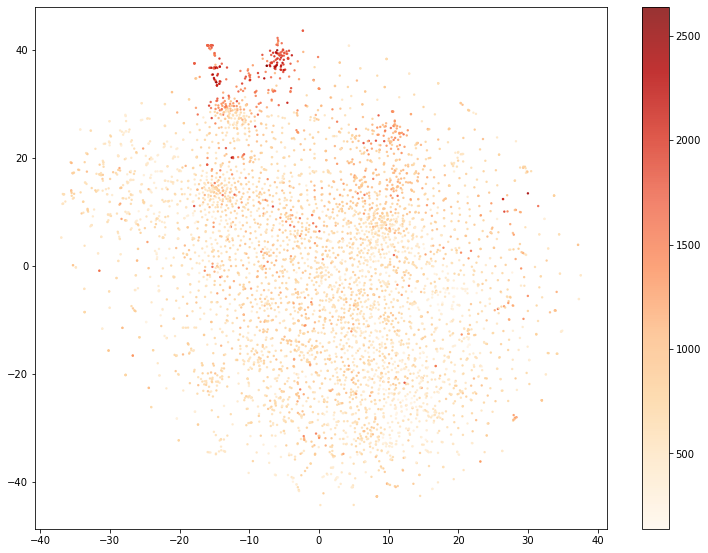

In [74]:
# colored based on input's weight
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['input_weight'], cmap='OrRd')
plt.colorbar()

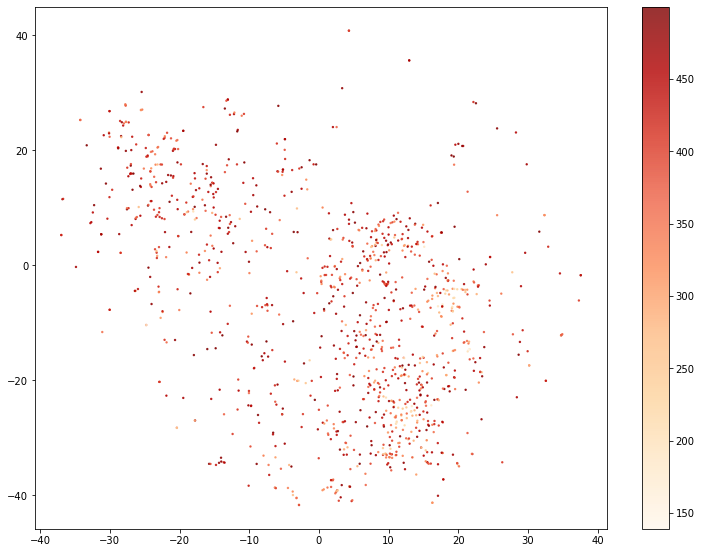

In [75]:
# colored based on input's weight (weight < 500)
index = np.array(test[test['input_weight'] < 500].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[test['input_weight'] < 500]['input_weight'], cmap='OrRd')
plt.colorbar()

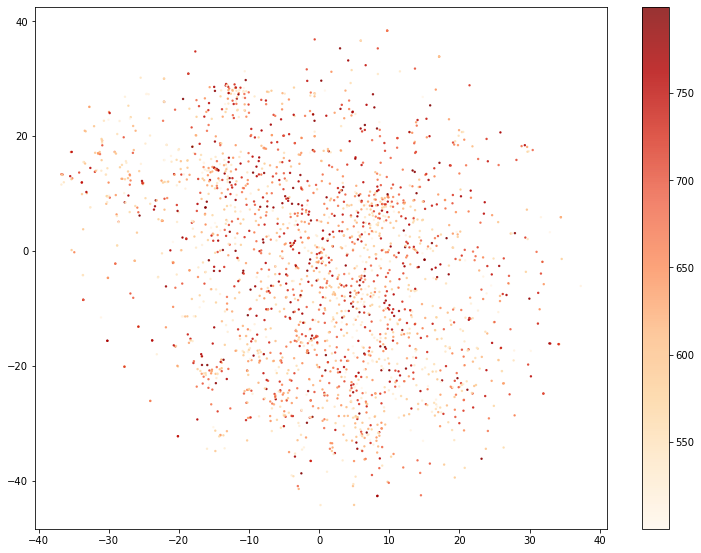

In [77]:
# colored based on input's weight (500 <= weight < 800)
index = np.array(test[(test['input_weight'] >= 500) & (test['input_weight'] < 800)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['input_weight'] >= 500) & (test['input_weight'] < 800)]['input_weight'], cmap='OrRd')
plt.colorbar()

In [3]:
# visualize cls embedding
outputs = np.load('/data2/sagawa/tcrp-multiinput-archive/12-3-agg-into-reagent-w-nodata/embedding_cls_5000.npy')[:, 0, :]
outputs.shape

(5000, 768)

/home/sagawa/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sagawa/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


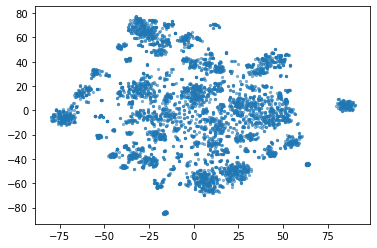

In [4]:
tsne = TSNE(n_components=2, random_state=42)
tsne_out = tsne.fit_transform(outputs)
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

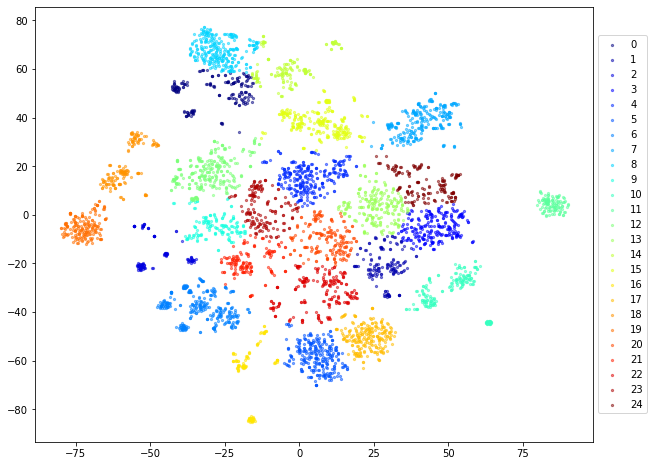

In [49]:
from sklearn.cluster import KMeans
cmap_keyword = "jet"
cmap = plt.get_cmap(cmap_keyword)
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(tsne_out)
labels = kmeans.labels_
test['cluster'] = labels

# cd = {0:'r', 1:'b', 2:'m', 3:'y', 4:'c', 5:'k', 6:'brown', 7:'pink', 8:'lime', 9:'lightcoral'}

fig, ax = plt.subplots(figsize=(10,8))
for cluster in range(n_clusters):
    data = tsne_out[labels==cluster]
    ax.scatter(data[:, 0], data[:, 1], alpha=0.5, s=5, color=cmap(cluster/(n_clusters-1)), label=cluster)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


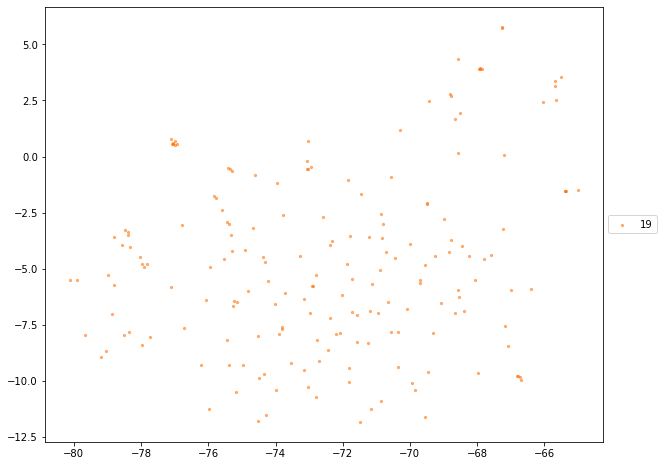

In [52]:
cluster = 19
fig, ax = plt.subplots(figsize=(10,8))
data = tsne_out[test['cluster'].values == cluster]
ax.scatter(data[:, 0], data[:, 1], alpha=0.5, s=5, color=cmap(cluster/(n_clusters-1)), label=cluster)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{' ': 'lightgrey', '[Pd]': 'aliceblue', 'c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1': 'antiquewhite', 'CN(C)c1ccncc1': 'aqua', 'CC(=O)[O-].[Pd+2]': 'aquamarine', 'O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.[Pd]': 'azure', '[Ni]': 'beige', '[Fe]': 'bisque', 'Cl[Pd]Cl.[Fe+2].c1ccc(P(c2ccccc2)[c-]2cccc2)cc1': 'black', '[Cu]I': 'blanchedalmond', 'CN(C)C=O': 'blue', 'Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1': 'blueviolet', '[OH-].[Pd+2]': 'brown', '[C].[Pd]': 'burlywood', '[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1': 'cadetblue', '[Zn]': 'chartreuse', '[Cl-].[Zn+2]': 'chocolate', 'CC[N+](CC)(CC)Cc1ccccc1.[Cl-]': 'coral', 'CCCC[N+](CCCC)(CCCC)CCCC.[I-]': 'cornflowerblue', 'COc1ccc(OC)c(P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C': 'cornsilk'}


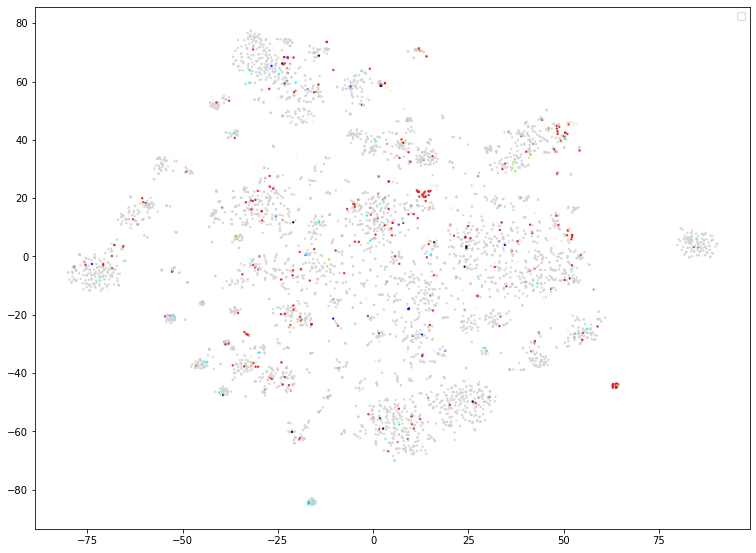

In [82]:
# colored based on catalyst
catalyst_c = {k: c for k, c in zip(test['CATALYST'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])}
catalyst_c.update({k: '#e41a1c' for k in test['CATALYST'].value_counts()[20:].keys()})
test['c'] = test['CATALYST'].map(catalyst_c)

plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, color=test['c'])
plt.legend()
print({k: c for k, c in zip(test['CATALYST'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])})

{' ': 'lightgrey', 'C1CCOC1': 'aliceblue', 'ClCCl': 'antiquewhite', 'CN(C)C=O': 'aqua', 'CO': 'aquamarine', 'O': 'azure', 'CCO': 'beige', 'CC#N': 'bisque', 'Cc1ccccc1': 'black', 'CC(=O)O': 'blanchedalmond', 'CCOC(C)=O': 'blue', 'c1ccncc1': 'blueviolet', 'CCOCC': 'brown', 'C1CCOC1.O': 'burlywood', 'C1COCCO1': 'cadetblue', 'CN(C)C=O.O': 'chartreuse', 'ClC(Cl)Cl': 'chocolate', 'CO.[Pd]': 'coral', 'CS(C)=O': 'cornflowerblue', 'CCO.[Pd]': 'cornsilk'}


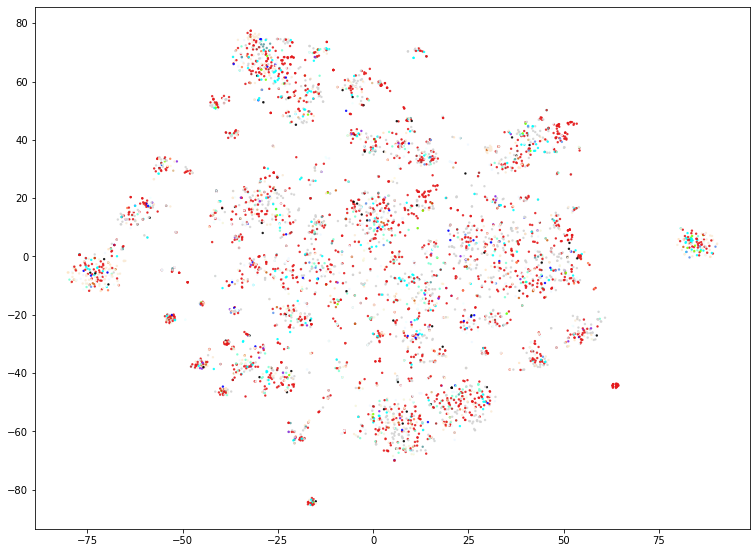

In [83]:
# colored based on reagent
reagent_c = {k: c for k, c in zip(test['REAGENT'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])}
reagent_c.update({k: '#e41a1c' for k in test['REAGENT'].value_counts()[20:].keys()})
test['c'] = test['REAGENT'].map(reagent_c)

plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, color=test['c'])
print({k: c for k, c in zip(test['REAGENT'].value_counts()[:20].keys(), ['lightgrey'] + colors[:19])})

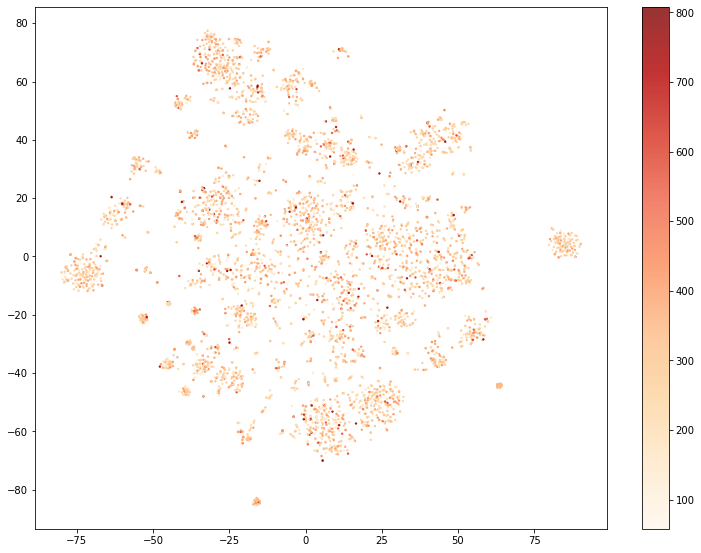

In [92]:
# colored based on product's weight
test['product_weight'] = test['PRODUCT'].apply(get_weight)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['product_weight'], cmap='OrRd')
plt.colorbar()

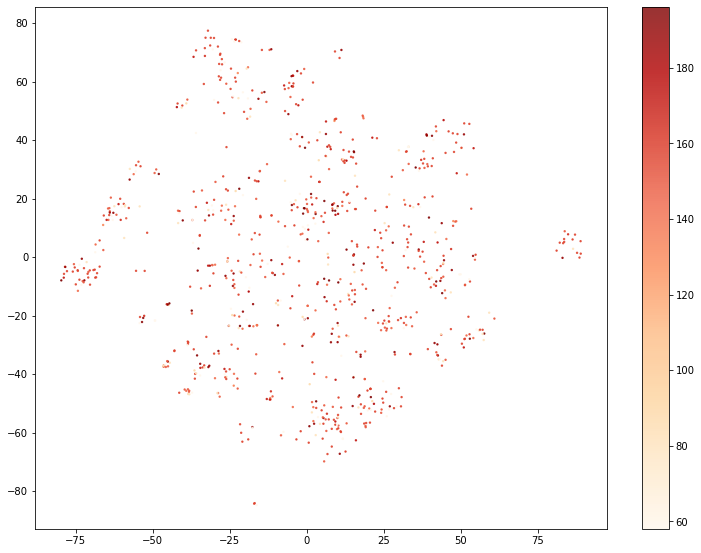

In [106]:
import matplotlib.cm as cm
index = np.array(test[test['product_weight'] < 200].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[test['product_weight'] < 200]['product_weight'], cmap='OrRd')
plt.colorbar()

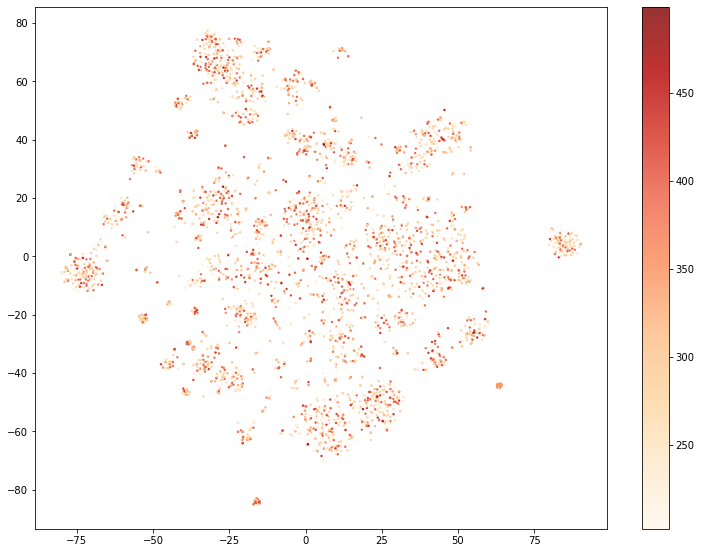

In [107]:
import matplotlib.cm as cm
index = np.array(test[(test['product_weight'] >= 200) & (test['product_weight'] < 500)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['product_weight'] >= 200) & (test['product_weight'] < 500)]['weight'], cmap='OrRd')
plt.colorbar()

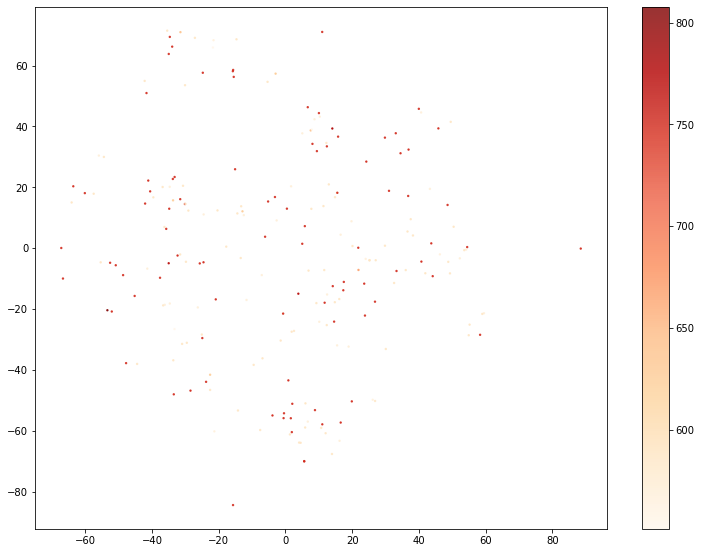

In [108]:
index = np.array(test[(test['product_weight'] >= 500)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['product_weight'] >= 500)]['product_weight'], cmap='OrRd')
plt.colorbar()

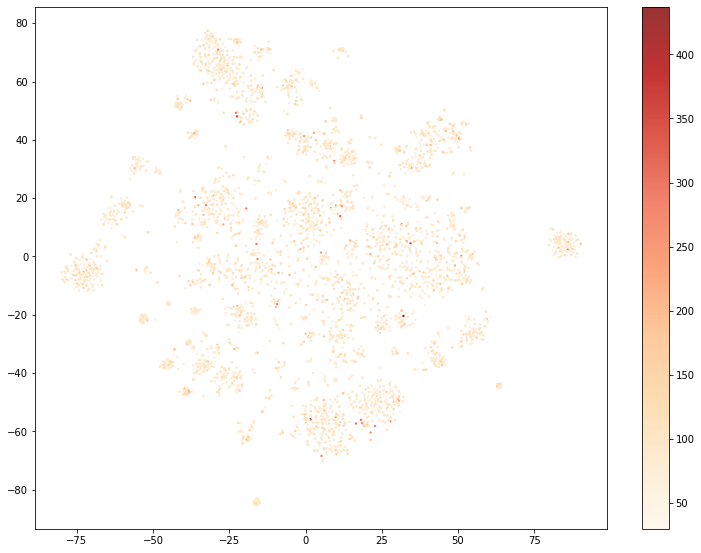

In [110]:
test['len'] = df.loc[test.index]['input'].str.len()
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['len'], cmap='OrRd')
plt.colorbar()

In [111]:
test['weight'] = test['REACTANT'].apply(get_weight)

[16:07:32] WARNING: not removing hydrogen atom without neighbors
[16:07:32] WARNING: not removing hydrogen atom without neighbors
[16:07:32] WARNING: not removing hydrogen atom without neighbors
[16:07:32] WARNING: not removing hydrogen atom without neighbors
[16:07:32] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not r

[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not removing hydrogen atom without neighbors
[16:07:33] WARNING: not r

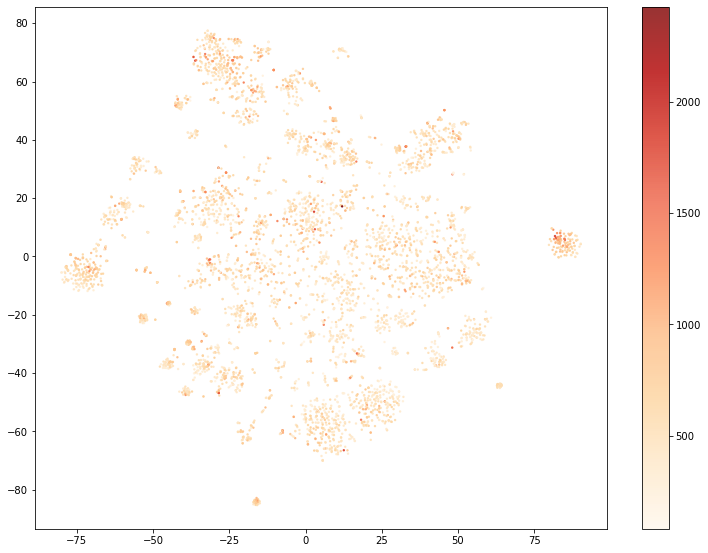

In [112]:
import matplotlib.cm as cm
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['weight'], cmap='OrRd')
plt.colorbar()

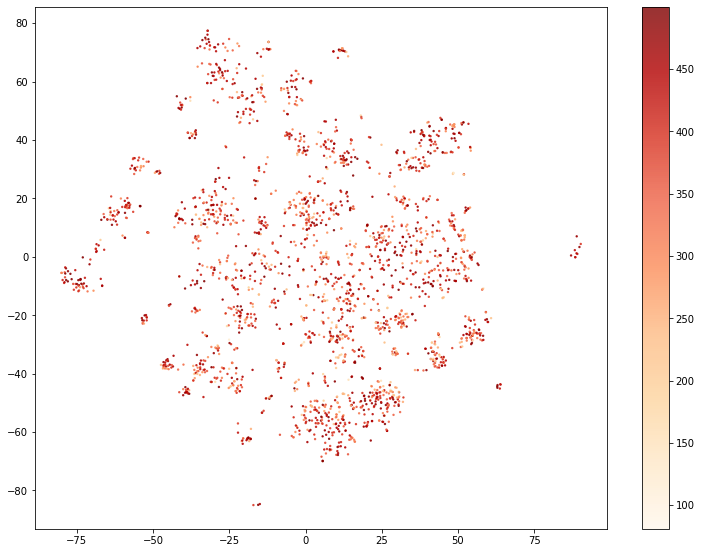

In [113]:
import matplotlib.cm as cm
index = np.array(test[test['weight'] < 500].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[test['weight'] < 500]['weight'], cmap='OrRd')
plt.colorbar()

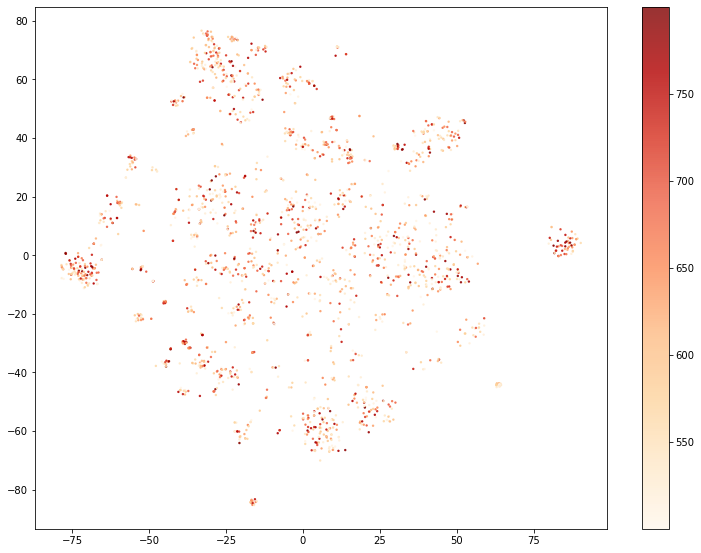

In [114]:
import matplotlib.cm as cm
index = np.array(test[(test['weight'] > 500) & (test['weight'] < 800)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['weight'] > 500) & (test['weight'] < 800)]['weight'], cmap='OrRd')
plt.colorbar()

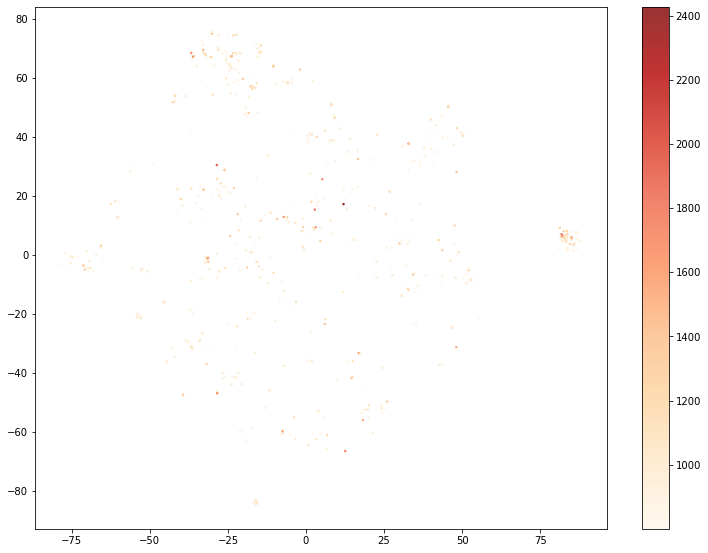

In [115]:
import matplotlib.cm as cm
index = np.array(test[(test['weight'] > 800)].index)
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[index, 0], tsne_out[index, 1], alpha=0.8, s=2, c=test[(test['weight'] > 800)]['weight'], cmap='OrRd')
plt.colorbar()

In [117]:
from rdkit.Chem import Descriptors
from rdkit import Chem
def get_weight(row):
    if row == ' ':
        return 0
    weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(row))
    return weight
test['weight_A'] = test['REAGENT'].apply(get_weight)
test['weight_S'] = test['SOLVENT'].apply(get_weight)
test['weight_R'] = test['REACTANT'].apply(get_weight)
test['weight'] = test['weight_A'] +test['weight_S'] +test['weight_R'] 

[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not removing hydrogen atom without neighbors
[16:08:45] WARNING: not r

[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not removing hydrogen atom without neighbors
[16:08:46] WARNING: not r

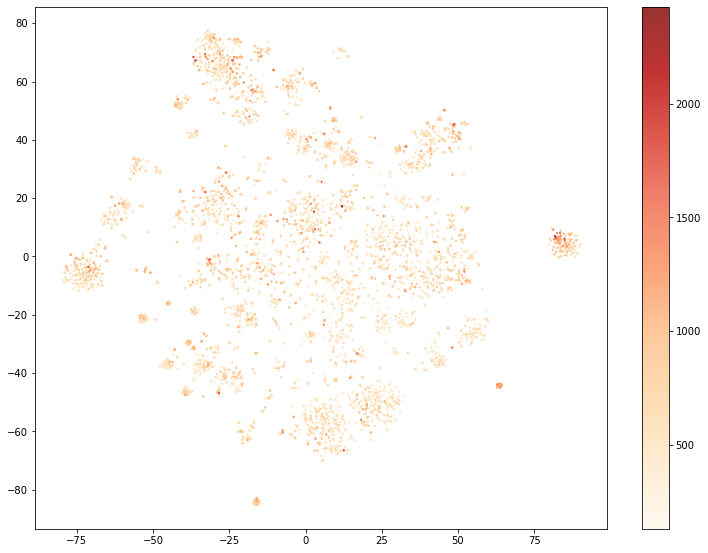

In [118]:
import matplotlib.cm as cm
plt.figure(figsize=[6.4*2, 4.8*2])
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.8, s=2, c=test['weight'], cmap='OrRd')
plt.colorbar()

(5000, 5000)

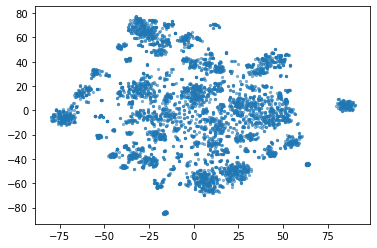

In [44]:
from sklearn.manifold import TSNE, MDS
tsne = TSNE(n_components=2, random_state=42)
tsne_out = tsne.fit_transform(outputs)
import matplotlib.pyplot as plt
plt.scatter(tsne_out[:, 0], tsne_out[:, 1], alpha=0.5, s=5)

In [17]:
test[tsne_out[:, 0] > 75]

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT
981745,CCN(C(C)C)C(C)C.Cl.N=C(N)n1cccn1.NCC(=O)Nc1ccc...,C[C@H](CO)CO[Si](c1ccccc1)(c1ccccc1)C(C)(C)C,,,CN(C)C=O
819165,CCN(C(C)C)C(C)C.COc1ccc([N+](=O)[O-])c(N)c1.NC...,Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1,,,CC#N
260129,CCN(C(C)C)C(C)C.CN(C)C(On1nnc2ccccc21)=[N+](C)...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,CN(C)C=O
13148,CCN(C(C)C)C(C)C.Nc1c(Cl)cc(C(=O)CBr)cc1C(F)(F)...,O=C(O)c1ccnn1-c1ccccc1,,,C1CCOC1
20937,CCN(C(C)C)C(C)C.CCN=C=NCCCN(C)C.CNOC.COc1cc(C(...,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,ClCCl
...,...,...,...,...,...
148904,CCN(C(C)C)C(C)C.CN(C)C=O.COC(=O)c1ccc(Cl)nc1.C...,Cc1cc(Cc2cc(C)c(O)c(C=O)c2C)c(C)c(C=O)c1O,,,CO
276542,CCN(C(C)C)C(C)C.COC(=O)Cl.Cl.N[C@@H]1CCN(C(=O)...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,ClCCl
776895,CCN(C(C)C)C(C)C.Cl.O=C(O)CC(=O)Nc1cc(-c2ccccc2...,CCCCCCCC/C=C\CCCCCCCC(=O)O,,,CN(C)C=O.O
826639,CCN(C(C)C)C(C)C.CCOC(=O)CCc1csc(N)n1.CN(C)C(On...,Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1,,,CS(C)=O


112
{'CCN(C(C)C)C(C)C': 112, 'Cl': 36, 'N=C(N)n1cccn1': 2, 'NCC(=O)Nc1ccc2oc(C(=O)Nc3ccc4[nH]c(C(=O)O)cc4c3)cc2c1': 1, 'COc1ccc([N+](=O)[O-])c(N)c1': 1, 'NCc1c(F)cc(Br)cc1F': 1, 'CN(C)C(On1nnc2ccccc21)=[N+](C)C': 11, 'Cc1onc(-c2ccc(F)cc2)c1COc1ccc(C(=O)O)cn1': 1, 'F[B-](F)(F)F': 6, 'O=S1(=O)CCNCC1': 1, 'Nc1c(Cl)cc(C(=O)CBr)cc1C(F)(F)F': 1, 'c1ccc(CCOCCCCCNCc2ccccc2)cc1': 1, 'CCN=C=NCCCN(C)C': 6, 'CNOC': 2, 'COc1cc(C(=O)O)ccc1C(F)(F)F': 1, 'O=C([O-])O': 5, 'On1nnc2ccccc21': 10, '[Na+]': 11, 'Cc1ccn2nc([C@H](C)N)n(-c3ccccc3)c(=O)c12': 1, 'Clc1ncnc2sc(Br)cc12': 1, 'CN(C)C1CNC1': 1, 'COc1cc(F)c([N+](=O)[O-])cc1Nc1nccc(-c2c[nH]c3ccccc23)n1': 1, 'COC(=O)CNc1c(C(=O)O)cccc1[N+](=O)[O-]': 1, '[N-]=[N+]=NP(=O)(c1ccccc1)c1ccccc1': 1, 'Nc1ccc(Oc2ccnc3cc(I)sc23)c(F)c1': 1, 'O=C(O)CC(=O)Nc1ccccc1': 1, 'O=C1OCCN1P(=O)(Cl)N1CCOC1=O': 1, 'CCOC(=O)CBr': 1, 'COc1ccc(C#N)cc1S(=O)(=O)NCCc1ccc(Br)cc1N': 1, 'O': 4, 'CCN(CC)c1ccc(NC(=O)c2cccc(C(=O)N(C)CCN3CCC[C@H]3C(=O)O)c2)c(-c2cc(C(=O)NCc3cccc(C(F)(F)F)c3)c

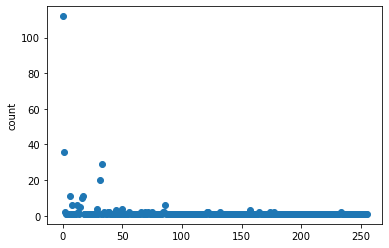

In [51]:
reactant_dic = {}
for idx, row in test[tsne_out[:, 0] > 75].iterrows():
    reactant = row['REACTANT']
    for rea in reactant.split('.'):
        try:
            reactant_dic[rea] += 1
        except:
            reactant_dic[rea] = 1
print(sum(tsne_out[:, 0] > 75))
plt.scatter(range(len(reactant_dic)), reactant_dic.values())
plt.ylabel('count')
print(reactant_dic)

In [18]:
test[tsne_out[:, 1] < -80]

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT
386401,CCN=C=NCCCN(C)C.Cn1nc(C2CC2)cc1Nc1ncc(Cl)c(NC2...,CCOC(=O)c1cccc(-c2cn(-c3ccc(F)c(F)c3)nc2C(=O)O...,,,CN(C)C=O.ClCCl
76089,CCN=C=NCCCN(C)C.CN(C)c1ccccn1.CN1C(=O)CCc2ccc(...,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,,,ClCCl
859148,CCN=C=NCCCN(C)C.Cl.Fc1ccccc1N1CCNCC1.Nc1onc(-c...,Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1,,,ClCCl
215423,CCN=C=NCCCN(C)C.CN1CCOCC1.C[C@H](NC(=O)OC(C)(C...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,ClCCl
35120,CCN=C=NCCCN(C)C.Cl.NC(=O)c1ccc2c(c1)c(-c1cccc(...,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,
494291,CCN=C=NCCCN(C)C.Cl.NC(Cc1ccccc1)C(O)C(F)(F)F.O...,CC1CO1,,,CN(C)C=O
636489,CCN=C=NCCCN(C)C.Cc1scc2c1c(=O)n(C)c(=O)n2C.Cl....,O=C(O)c1cccc(Cl)c1,CN(C)c1ccncc1,,ClCCCl
794582,CCN=C=NCCCN(C)C.COc1cc(N)cc(OC)c1OC.O=C(O)CCCC...,NN=C(C=Cc1ccccc1)c1ccccc1,,,CN(C)C=O
362690,CCN=C=NCCCN(C)C.COc1ccc(CNC(=S)NNC(=O)c2ccc3[n...,CCOC(=O)c1cccc(-c2cn(-c3ccc(F)c(F)c3)nc2C(=O)O...,,,Cc1ccccc1
710432,CCN=C=NCCCN(C)C.CCOC(=O)C(C)(CCC(C)C)CNCc1ccc(...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,,,CN(C)C=O


28
{'CCN=C=NCCCN(C)C': 28, 'Cn1nc(C2CC2)cc1Nc1ncc(Cl)c(NC2CC3CNCC3C2)n1': 1, 'N#CCC(=O)O': 1, 'On1nnc2cccnc21': 2, 'CN(C)c1ccccn1': 1, 'CN1C(=O)CCc2ccc(N)cc21': 1, 'Cl': 20, 'O=C(O)c1ccc(Cl)cc1N[C@H]1CCCC[C@@H]1N1CCCC1': 1, 'Fc1ccccc1N1CCNCC1': 1, 'Nc1onc(-c2ccc(OC(F)(F)F)cc2)c1C(=O)O': 1, 'CN1CCOCC1': 4, 'C[C@H](NC(=O)OC(C)(C)C)C(=O)O': 1, 'Nc1ccc(F)cc1NC1CC1': 1, 'NC(=O)c1ccc2c(c1)c(-c1cccc(N)c1)nn2C1CCCCO1': 1, 'O=C(O)Cc1ccccn1': 1, 'NC(Cc1ccccc1)C(O)C(F)(F)F': 1, 'O=C(O)Cn1cncc(NC(=O)OCc2ccccc2)c1=O': 1, 'On1nnc2ccccc21': 12, 'Cc1scc2c1c(=O)n(C)c(=O)n2C': 1, 'Nc1nc(-c2ccc(F)c(OC(F)(F)F)c2)cs1': 1, 'COc1cc(N)cc(OC)c1OC': 1, 'O=C(O)CCCCCBr': 1, 'COc1ccc(CNC(=S)NNC(=O)c2ccc3[nH]ccc3c2)cc1': 1, 'CCOC(=O)C(C)(CCC(C)C)CNCc1ccc(F)cc1': 1, 'CS(=O)(=O)Nc1ccc2c(c1)S(=O)(=O)N=C(CC(=O)O)N2': 1, '[H-]': 1, '[Na+]': 3, 'CCOC(=O)C1CN(C(=O)OC(C)(C)C)CCN1': 1, 'Cc1ccc(C(=O)O)cn1': 1, 'N#Cc1ccc2c(c1)c(-c1cccc(C(=O)O)c1)nn2C1CCCCO1': 1, 'NCCN1CCCCC1': 1, 'CCOC(=O)CCN1CCC(N)CC1': 1, 'COC(=O)NC(=N)c1cc

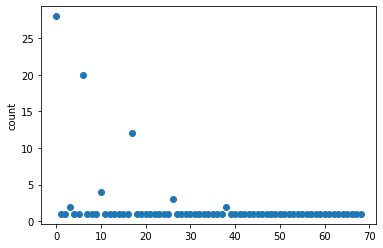

In [52]:
reactant_dic = {}
for idx, row in test[tsne_out[:, 1] < -80].iterrows():
    reactant = row['REACTANT']
    for rea in reactant.split('.'):
        try:
            reactant_dic[rea] += 1
        except:
            reactant_dic[rea] = 1
print(sum(tsne_out[:, 1] < -80))
plt.scatter(range(len(reactant_dic)), reactant_dic.values())
plt.ylabel('count')
print(reactant_dic)

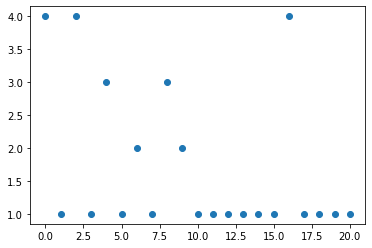

In [38]:
reactant_dic = {}
for idx, row in test[tsne_out[:, 1] < -80].iterrows():
    reactant = row['PRODUCT']
    for rea in reactant.split('.'):
        try:
            reactant_dic[rea] += 1
        except:
            reactant_dic[rea] = 1
            
plt.scatter(range(len(reactant_dic)), reactant_dic.values())


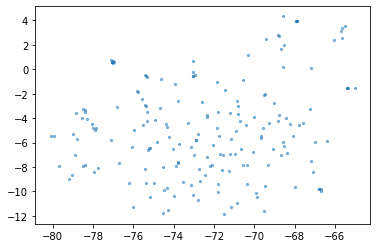

In [46]:
plt.scatter(tsne_out[(tsne_out[:, 0]<-62.5) & (tsne_out[:, 1]<5)][:, 0], tsne_out[(tsne_out[:, 0]<-62.5) & (tsne_out[:, 1]<5)][:, 1], alpha=0.5, s=5)

186
{'CCN(CC)CC': 162, 'CCOC(C)=O': 4, 'Cl': 45, 'O=C(O)c1cnc2c(Br)cnn2c1O': 1, 'c1ccc(C2CCNCC2)cc1': 1, 'CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2C)cc1': 1, 'O=C(O)c1ccc(B(O)O)cc1': 1, 'O=C([O-])[O-]': 4, '[Na+]': 16, 'COc1cc2nccc(Oc3ccc(N)c(C)c3C)c2cc1OC': 2, 'C[C@H](N)c1ccc(F)cc1': 1, 'O=C(OC(Cl)(Cl)Cl)OC(Cl)(Cl)Cl': 4, 'N#Cc1ccc(N)cc1': 1, 'O=C(Cl)C(=O)Cl': 12, 'O=C(O)C(C1CCCCC1)n1c(-c2ccc(Cl)cc2)nc2cc(F)c(F)cc21': 1, 'CCN=C=NCCCN(C)C': 7, 'NC1CCN(Cc2ccccc2)CC1': 1, 'O': 19, 'O=C(O)c1ccc(NCc2ccnc3ccccc23)cc1': 1, 'On1nnc2ccccc21': 6, 'Cc1ccc(S(=O)(=O)O)cc1': 2, 'FC(F)(F)Oc1ccc(OC2CCNCC2)cc1': 1, 'O=C1CCC(=O)CC1': 1, 'COc1ccc(C=CC(=O)O)c(OC)c1OC': 1, 'O=C([O-])O': 6, 'O=S(Cl)Cl': 4, 'c1ccc(C(c2ccccc2)N2CCNCC2)cc1': 1, 'O=C(NCCCl)NC(c1ccccc1)C(F)(F)F': 1, 'Cc1nc2ccccc2n1C1CC2CCC(C1)N2CCC1(c2ccccc2)CCNCC1': 1, 'O=C(Cl)Cl': 1, 'CCOP(=O)(C#N)OCC': 3, 'CN': 2, 'O=C(O)c1ccc(C(=O)NCCNc2nsc3ccccc23)nc1': 1, 'COc1ccc(N)cc1N1CCN(C)CC1': 1, 'O=C(O)c1coc(Br)c1': 1, 'Nc1cc(F)c(Oc2ccncc2Br)c

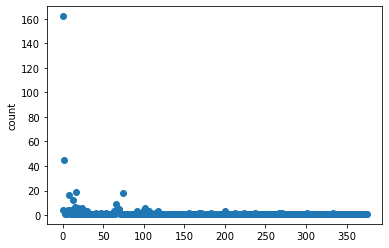

In [54]:
reactant_dic = {}
for idx, row in test[(tsne_out[:, 0]<-62.5) & (tsne_out[:, 1]<5)].iterrows():
    reactant = row['REACTANT']
    for rea in reactant.split('.'):
        try:
            reactant_dic[rea] += 1
        except:
            reactant_dic[rea] = 1
print(sum((tsne_out[:, 0]<-62.5) & (tsne_out[:, 1]<5)))
plt.scatter(range(len(reactant_dic)), reactant_dic.values())
plt.ylabel('count')
print(reactant_dic)

In [48]:
test[(tsne_out[:, 0]<-62.5) & (tsne_out[:, 1]<5)]

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT
242194,CCN(CC)CC.CCOC(C)=O.Cl.O=C(O)c1cnc2c(Br)cnn2c1...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,ClCCl
550195,CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2...,COc1nc(N2CCCC2)ccc1[N+](=O)[O-],,,CCO
1018538,CCN(CC)CC.COc1cc2nccc(Oc3ccc(N)c(C)c3C)c2cc1OC...,CNC(=O)c1ncn2c(C)cc(C)[n+](C)c12.[Cl-],,,ClC(Cl)Cl
707403,CCN(CC)CC.N#Cc1ccc(N)cc1.O=C(Cl)C(=O)Cl.O=C(O)...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,,,ClCCl
1060214,CCN(CC)CC.CCN=C=NCCCN(C)C.Cl.NC1CCN(Cc2ccccc2)...,O=C(O)c1cc(-n2c(=O)cc(C(F)(F)F)[nH]c2=O)ccc1Cl,,,CN(C)C=O
...,...,...,...,...,...
244279,CCN(CC)CC.COc1ccc(F)cc1C(C)(C)CC(O)C1(F)CC1.CS...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,ClCCl
84779,CCN(CC)CC.Cl.NCCF.O=S(=O)(Cl)Cc1cc(C(F)(F)F)cc...,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,,,ClCCl
481880,CCCN(CCC)C1CCc2oc3ccc(N)cc3c2C1.O=C(Cl)c1ccoc1,Oc1cc2cc[nH]c2cc1O,,,
634209,CCN(CC)CC.NCc1cn(-c2ccccc2)c2cc(Cl)ccc2c1=O.O=...,O=C(O)c1cccc(Cl)c1,,,ClCCl


In [55]:
indices = []
for idx, row in test[(tsne_out[:, 0]<-62.5) & (tsne_out[:, 1]<5)].iterrows():
    reactant = row['REACTANT']
    if 'CCN(CC)CC' not in reactant:
        print(idx)
        indices.append(idx)

550195
706288
291881
37259
242015
868835
526938
38085
113683
792540
1015763
443308
109028
888805
686834
264660
203053
481880


In [57]:
test.loc[indices]

,REACTANT,PRODUCT,CATALYST,REAGENT,SOLVENT
550195,CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2...,COc1nc(N2CCCC2)ccc1[N+](=O)[O-],,,CCO
706288,COCCN(CCOC)S(F)(F)F.Cc1ncc(CN(C(=O)OC(C)(C)C)c...,O=S(=O)([O-])[O-].O=S(=O)([O-])[O-].O=S(=O)([O...,,,ClCCl
291881,CCN(CC)S(F)(F)F.CCn1nc(-c2cccc(C(C)(C)NS(=O)(=...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,ClCCl
37259,CCCN(CCC)C(=O)c1cc(C(N)=O)cc(C(=O)O)c1.CN1CCOC...,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,CN(C)C=O
242015,CCN(CC)S(F)(F)F.COCC1(O)CCN(c2ccc(N3C[C@H](CNC...,c1ccc2sc(-c3nccc4ccccc34)cc2c1,,,ClCCl
868835,CCN(CC)c1ccc([C@H](CO)NC(=O)OC(C)(C)C)cc1.NC1C...,Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1,I[Cu]I,,
526938,CCCN(CCC)CCC.COc1ccc(S(=O)(=O)N2CC=CCC(C(=O)O)...,COc1nc(N2CCCC2)ccc1[N+](=O)[O-],,,C1COCCO1
38085,CCN(CC)C(=O)c1cccc2c(C[C@@H](C)N3C[C@@H](c4ccc...,CC(C)CN=C1C(c2ccccc2)=C(c2ccccc2)C(c2ccccc2)=C...,,,CC(C)=O
113683,CCN(CC)S(F)(F)F.O=C([O-])O.OC1(c2cccc(F)c2F)CC...,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,,,ClCCl
792540,CCN(CC)C(=O)c1ccc(C(O)(c2cccc3cccnc23)C2CCN(C(...,NN=C(C=Cc1ccccc1)c1ccccc1,,,CCOC(C)=O


18
{'CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2C)cc1': 1, 'O=C(O)c1ccc(B(O)O)cc1': 1, 'O=C([O-])[O-]': 2, '[Na+]': 5, 'COCCN(CCOC)S(F)(F)F': 1, 'Cc1ncc(CN(C(=O)OC(C)(C)C)c2ccc(C#N)cc2)c(C(C)O)c1OCc1cccc(C#N)c1': 1, 'O=C([O-])O': 3, 'CCN(CC)S(F)(F)F': 3, 'CCn1nc(-c2cccc(C(C)(C)NS(=O)(=O)CC(F)(F)F)c2)cc1Oc1ccc(C(C)O)cc1': 1, 'CCCN(CCC)C(=O)c1cc(C(N)=O)cc(C(=O)O)c1': 1, 'CN1CCOCC1': 1, 'Cl': 1, 'ClCCCl': 1, 'N[C@@H](Cc1cc(F)cc(F)c1)[C@H](O)CN(Cc1cccc(I)c1)C(=O)OCC1c2ccccc2-c2ccccc21': 1, 'On1nnc2ccccc21': 1, 'COCC1(O)CCN(c2ccc(N3C[C@H](CNC(C)=O)OC3=O)cc2F)CC1': 1, 'CCN(CC)c1ccc([C@H](CO)NC(=O)OC(C)(C)C)cc1': 1, 'NC1CCCCC1N': 1, 'O=CO': 1, 'O=S(Cl)Cl': 1, '[Cs+]': 1, '[F-]': 1, 'CCCN(CCC)CCC': 1, 'COc1ccc(S(=O)(=O)N2CC=CCC(C(=O)O)C2C(=O)OC(C)(C)C)cc1': 1, '[N-]=[N+]=NP(=O)(c1ccccc1)c1ccccc1': 1, 'c1ccc(CNCc2ccccc2)cc1': 1, 'CCN(CC)C(=O)c1cccc2c(C[C@@H](C)N3C[C@@H](c4cccc(Cl)c4)OC3=O)c[nH]c12': 1, 'CI': 1, '[K+]': 1, 'OC1(c2cccc(F)c2F)CCN(Cc2ccccc2)C1': 1, 'CCN(CC)C(=O)c1ccc(C(O)(c2cccc

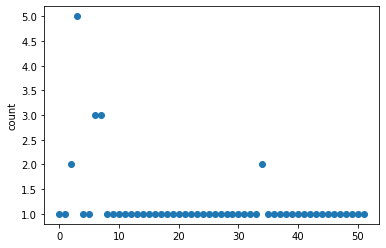

In [60]:
reactant_dic = {}
for idx, row in test.loc[indices].iterrows():
    reactant = row['REACTANT']
    for rea in reactant.split('.'):
        try:
            reactant_dic[rea] += 1
        except:
            reactant_dic[rea] = 1
print(len(test.loc[indices]))
plt.scatter(range(len(reactant_dic)), reactant_dic.values())
plt.ylabel('count')
print(reactant_dic)

In [61]:
RD(reactant_dic)

dict_keys(['CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2C)cc1', 'O=C(O)c1ccc(B(O)O)cc1', 'O=C([O-])[O-]', '[Na+]', 'COCCN(CCOC)S(F)(F)F', 'Cc1ncc(CN(C(=O)OC(C)(C)C)c2ccc(C#N)cc2)c(C(C)O)c1OCc1cccc(C#N)c1', 'O=C([O-])O', 'CCN(CC)S(F)(F)F', 'CCn1nc(-c2cccc(C(C)(C)NS(=O)(=O)CC(F)(F)F)c2)cc1Oc1ccc(C(C)O)cc1', 'CCCN(CCC)C(=O)c1cc(C(N)=O)cc(C(=O)O)c1', 'CN1CCOCC1', 'Cl', 'ClCCCl', 'N[C@@H](Cc1cc(F)cc(F)c1)[C@H](O)CN(Cc1cccc(I)c1)C(=O)OCC1c2ccccc2-c2ccccc21', 'On1nnc2ccccc21', 'COCC1(O)CCN(c2ccc(N3C[C@H](CNC(C)=O)OC3=O)cc2F)CC1', 'CCN(CC)c1ccc([C@H](CO)NC(=O)OC(C)(C)C)cc1', 'NC1CCCCC1N', 'O=CO', 'O=S(Cl)Cl', '[Cs+]', '[F-]', 'CCCN(CCC)CCC', 'COc1ccc(S(=O)(=O)N2CC=CCC(C(=O)O)C2C(=O)OC(C)(C)C)cc1', '[N-]=[N+]=NP(=O)(c1ccccc1)c1ccccc1', 'c1ccc(CNCc2ccccc2)cc1', 'CCN(CC)C(=O)c1cccc2c(C[C@@H](C)N3C[C@@H](c4cccc(Cl)c4)OC3=O)c[nH]c12', 'CI', '[K+]', 'OC1(c2cccc(F)c2F)CCN(Cc2ccccc2)C1', 'CCN(CC)C(=O)c1ccc(C(O)(c2cccc3cccnc23)C2CCN(C(=O)OC(C)(C)C)CC2)cc1', 'O=C(O)C(F)(F)F', 'CCCN(C)C(=O)c1cc(I)cc(C(

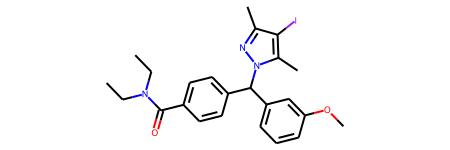

In [68]:
Chem.MolFromSmiles('CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2C)cc1')

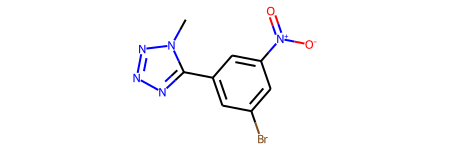

In [72]:
Chem.MolFromSmiles('Cn1nnnc1-c1cc(Br)cc([N+](=O)[O-])c1	')

In [67]:
for idx, row in test.loc[indices].iterrows():
    reactant = row['REACTANT']
    for rea in reactant.split('.'):
        print(rea)
        break

CCN(CC)C(=O)c1ccc(C(c2cccc(OC)c2)n2nc(C)c(I)c2C)cc1
COCCN(CCOC)S(F)(F)F
CCN(CC)S(F)(F)F
CCCN(CCC)C(=O)c1cc(C(N)=O)cc(C(=O)O)c1
CCN(CC)S(F)(F)F
CCN(CC)c1ccc([C@H](CO)NC(=O)OC(C)(C)C)cc1
CCCN(CCC)CCC
CCN(CC)C(=O)c1cccc2c(C[C@@H](C)N3C[C@@H](c4cccc(Cl)c4)OC3=O)c[nH]c12
CCN(CC)S(F)(F)F
CCN(CC)C(=O)c1ccc(C(O)(c2cccc3cccnc23)C2CCN(C(=O)OC(C)(C)C)CC2)cc1
CCCN(C)C(=O)c1cc(I)cc(C(=O)OC)c1
CN(CCCl)CCCl
CCN(CC)c1ccccc1
CCN(CC)C(=O)c1ccc(C2(c3cccc(O)c3)CCN(Cc3ccccc3)CC2)cc1
CCCN(CC)C(=O)c1cc(I)cc(C(=O)OC)c1
CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C
CCN(CC)S(=O)(=O)c1cc(C(=O)CCl)ccc1Cl
CCCN(CCC)C1CCc2oc3ccc(N)cc3c2C1
